In [2]:
import numpy as np
import pandas as pd
import matplotlib as plt
import re
import lightgbm as lgb
import datetime as dt
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

In [3]:
borrar = ["Opportunity_Name", "ID", "Brand", "Product_Type", "ASP_converted_Currency", 
          "Prod_Category_A", "Product_Category_B", "Actual_Delivery_Date", "Last_Activity", 
          "ASP_converted_Currency", "Prod_Category_A", "Product_Name", "Delivery_Year", "Month", 
          "TRF", "Product_Family", "Account_Name"]

useless = ["Submitted_for_Approval", "Account_Type", "Delivery_Terms", "Size", "Price", "ASP_Currency", 
           "Total_Amount_Currency", "Total_Taxable_Amount_Currency","Quote_Type", "Opportunity_Type"] # "Product_Category_B", "Region"]

dates = ["Account_Created_Date", "Opportunity_Created_Date", "Quote_Expiry_Date", "Last_Modified_Date", 
         "Planned_Delivery_Start_Date", "Planned_Delivery_End_Date"]

target = ["Opportunity_ID", "Stage", "Sales_Contract_No"]

In [4]:
def preprocess(data):
    
    # elimino caracteres prohibidos en los headers
    
    data = data.rename(columns = lambda x:re.sub("[^A-Za-z0-9_]+", "", x))
        
    for d in dates:
        data[d] = pd.to_datetime(data[d])

    # agrego features
    
    data["Contacts"] = data.groupby("Opportunity_ID", sort = False)["Opportunity_ID"].transform("count")
    data["Delivery_Difference"] = (data["Planned_Delivery_End_Date"] - data["Planned_Delivery_Start_Date"]).dt.days
    data["Same_Owner"] = (data.Opportunity_Owner == data.Account_Owner) & (data.Opportunity_Owner == data.Last_Modified_By)
    data["Has_Brand"] = data.Brand != "None"
    data["Has_Contract"] = data.Sales_Contract_No != "None"
    data["Different_Country"] = (data.Billing_Country != data.Territory) & (data.Territory != "None")    
    data.loc[data.TRF == 0, "TRF_Cat"] = 0
    data.loc[(1 <= data.TRF) & (data.TRF <= 7), "TRF_Cat"] = 1
    data.loc[data.TRF > 7, "TRF_Cat"] = 2
    data["Sales"] = data.groupby("Account_Name", sort = False)["Account_Name"].transform("count")
    
    data["Concrete_Offer"] = (data["Planned_Delivery_End_Date"] - data["Opportunity_Created_Date"]).dt.days
    
    data["Offer_Duration"] = (data["Quote_Expiry_Date"] - data["Opportunity_Created_Date"]).dt.days
    
    # fabri
    
    data["Territory_Defined"] = data.Territory != "None"
    data["Past_Quote"] = (data["Last_Modified_Date"] - data["Quote_Expiry_Date"]).dt.days
    
    # casteo a categoricas varias columnas
    categorical = [x for x in data.columns if data[x].dtype == "object"]
    for c in categorical:       
        data[c] = data[c].astype('category')
        
    # limpio columnas
    
    data = data.drop(borrar + useless + dates, axis = 1)
    
    #data.drop(data[(data.Contacts > 1) & (data.ASP.isna())].index, inplace = True)
    #data = data.drop_duplicates([x for x in data.columns if x != 'ID'])
    
    return (data)

In [5]:
import catboost as ctb

In [6]:
data = pd.read_csv("Entrenamieto_ECI_2020.csv")

In [7]:
rest = [x for x in data.columns if x != 'ID']
len(data[data.duplicated(rest)])/float(len(data)) * 100

2.643535729037588

In [8]:
prep = preprocess(data)

In [9]:
prep = prep[(prep.Stage == "Closed Won") | (prep.Stage == "Closed Lost")]
prep.Stage = prep.Stage.replace({"Closed Won": 1, "Closed Lost": 0})

In [10]:
len(prep[prep.duplicated()])

481

In [12]:
x_train, x_test, y_train, y_test = train_test_split(prep, prep.Stage, test_size = 0.3, random_state = 0, stratify = prep.Stage)

In [13]:
cat_vars = [x for x in x_train.drop(target, axis=1).select_dtypes('category').columns if x != 'Stage']

In [14]:
cat_vars

['Region',
 'Territory',
 'Bureaucratic_Code',
 'Source',
 'Billing_Country',
 'Account_Owner',
 'Opportunity_Owner',
 'Currency',
 'Last_Modified_By',
 'Delivery_Quarter']

In [15]:
cat_indexes = [x_train.drop(target, axis=1).columns.get_loc(x) for x in cat_vars]

In [16]:
cat_indexes

[0, 1, 6, 7, 8, 9, 10, 11, 12, 15]

In [17]:
model = ctb.CatBoostClassifier(num_boost_round = 5000,
                               learning_rate = 0.015,
                               l2_leaf_reg = 3.5,
                               depth = 8, 
                               max_bin = 400,
                               num_leaves = 31,
                               rsm = 0.98,
                               eval_metric = 'Logloss',
                               use_best_model = True,
                               random_seed = 42)

In [18]:
model.fit(x_train.drop(target, axis = 1), y_train, eval_set = (x_test.drop(target, axis = 1), y_test), cat_features = cat_indexes, early_stopping_rounds = 800)

0:	learn: 0.6679047	test: 0.6680119	best: 0.6680119 (0)	total: 167ms	remaining: 13m 57s
1:	learn: 0.6445301	test: 0.6446755	best: 0.6446755 (1)	total: 244ms	remaining: 10m 10s
2:	learn: 0.6215882	test: 0.6218183	best: 0.6218183 (2)	total: 329ms	remaining: 9m 7s
3:	learn: 0.5997478	test: 0.6001257	best: 0.6001257 (3)	total: 405ms	remaining: 8m 25s
4:	learn: 0.5797157	test: 0.5801344	best: 0.5801344 (4)	total: 501ms	remaining: 8m 20s
5:	learn: 0.5588156	test: 0.5591815	best: 0.5591815 (5)	total: 573ms	remaining: 7m 56s
6:	learn: 0.5415626	test: 0.5420385	best: 0.5420385 (6)	total: 648ms	remaining: 7m 42s
7:	learn: 0.5229923	test: 0.5234632	best: 0.5234632 (7)	total: 764ms	remaining: 7m 56s
8:	learn: 0.5062847	test: 0.5069144	best: 0.5069144 (8)	total: 853ms	remaining: 7m 52s
9:	learn: 0.4884993	test: 0.4891454	best: 0.4891454 (9)	total: 1.05s	remaining: 8m 42s
10:	learn: 0.4735569	test: 0.4741978	best: 0.4741978 (10)	total: 1.11s	remaining: 8m 23s
11:	learn: 0.4574735	test: 0.4582260	bes

93:	learn: 0.1199041	test: 0.1303920	best: 0.1303920 (93)	total: 7.95s	remaining: 6m 54s
94:	learn: 0.1189598	test: 0.1296424	best: 0.1296424 (94)	total: 8.03s	remaining: 6m 54s
95:	learn: 0.1182406	test: 0.1290309	best: 0.1290309 (95)	total: 8.11s	remaining: 6m 54s
96:	learn: 0.1174511	test: 0.1283625	best: 0.1283625 (96)	total: 8.22s	remaining: 6m 55s
97:	learn: 0.1166388	test: 0.1276245	best: 0.1276245 (97)	total: 8.3s	remaining: 6m 55s
98:	learn: 0.1157753	test: 0.1269419	best: 0.1269419 (98)	total: 8.38s	remaining: 6m 54s
99:	learn: 0.1155771	test: 0.1267581	best: 0.1267581 (99)	total: 8.4s	remaining: 6m 51s
100:	learn: 0.1149537	test: 0.1262526	best: 0.1262526 (100)	total: 8.5s	remaining: 6m 52s
101:	learn: 0.1146281	test: 0.1259281	best: 0.1259281 (101)	total: 8.53s	remaining: 6m 49s
102:	learn: 0.1138141	test: 0.1252803	best: 0.1252803 (102)	total: 8.62s	remaining: 6m 49s
103:	learn: 0.1131724	test: 0.1247284	best: 0.1247284 (103)	total: 8.7s	remaining: 6m 49s
104:	learn: 0.112

186:	learn: 0.0872484	test: 0.1047677	best: 0.1047677 (186)	total: 16s	remaining: 6m 53s
187:	learn: 0.0870958	test: 0.1046030	best: 0.1046030 (187)	total: 16.1s	remaining: 6m 52s
188:	learn: 0.0870168	test: 0.1045438	best: 0.1045438 (188)	total: 16.2s	remaining: 6m 52s
189:	learn: 0.0867371	test: 0.1042745	best: 0.1042745 (189)	total: 16.3s	remaining: 6m 52s
190:	learn: 0.0864255	test: 0.1040394	best: 0.1040394 (190)	total: 16.4s	remaining: 6m 52s
191:	learn: 0.0861313	test: 0.1038131	best: 0.1038131 (191)	total: 16.5s	remaining: 6m 52s
192:	learn: 0.0859385	test: 0.1036770	best: 0.1036770 (192)	total: 16.6s	remaining: 6m 52s
193:	learn: 0.0856827	test: 0.1035167	best: 0.1035167 (193)	total: 16.7s	remaining: 6m 52s
194:	learn: 0.0856160	test: 0.1034876	best: 0.1034876 (194)	total: 16.8s	remaining: 6m 52s
195:	learn: 0.0854361	test: 0.1033475	best: 0.1033475 (195)	total: 16.9s	remaining: 6m 53s
196:	learn: 0.0852577	test: 0.1032153	best: 0.1032153 (196)	total: 16.9s	remaining: 6m 52s
1

278:	learn: 0.0745433	test: 0.0957241	best: 0.0957241 (278)	total: 23.6s	remaining: 6m 39s
279:	learn: 0.0744639	test: 0.0956791	best: 0.0956791 (279)	total: 23.7s	remaining: 6m 39s
280:	learn: 0.0744488	test: 0.0956632	best: 0.0956632 (280)	total: 23.8s	remaining: 6m 39s
281:	learn: 0.0744005	test: 0.0956167	best: 0.0956167 (281)	total: 23.8s	remaining: 6m 38s
282:	learn: 0.0742435	test: 0.0955054	best: 0.0955054 (282)	total: 23.9s	remaining: 6m 39s
283:	learn: 0.0741128	test: 0.0953982	best: 0.0953982 (283)	total: 24.1s	remaining: 6m 40s
284:	learn: 0.0740252	test: 0.0953534	best: 0.0953534 (284)	total: 24.2s	remaining: 6m 41s
285:	learn: 0.0738392	test: 0.0952603	best: 0.0952603 (285)	total: 24.3s	remaining: 6m 40s
286:	learn: 0.0737008	test: 0.0951776	best: 0.0951776 (286)	total: 24.4s	remaining: 6m 41s
287:	learn: 0.0736646	test: 0.0951637	best: 0.0951637 (287)	total: 24.5s	remaining: 6m 41s
288:	learn: 0.0735878	test: 0.0951095	best: 0.0951095 (288)	total: 24.6s	remaining: 6m 41s

371:	learn: 0.0675952	test: 0.0914200	best: 0.0914200 (371)	total: 31.1s	remaining: 6m 27s
372:	learn: 0.0675667	test: 0.0914011	best: 0.0914011 (372)	total: 31.2s	remaining: 6m 27s
373:	learn: 0.0675337	test: 0.0913848	best: 0.0913848 (373)	total: 31.3s	remaining: 6m 27s
374:	learn: 0.0674700	test: 0.0913444	best: 0.0913444 (374)	total: 31.4s	remaining: 6m 27s
375:	learn: 0.0673504	test: 0.0912496	best: 0.0912496 (375)	total: 31.5s	remaining: 6m 26s
376:	learn: 0.0672613	test: 0.0912150	best: 0.0912150 (376)	total: 31.5s	remaining: 6m 26s
377:	learn: 0.0672443	test: 0.0912018	best: 0.0912018 (377)	total: 31.6s	remaining: 6m 26s
378:	learn: 0.0672215	test: 0.0911826	best: 0.0911826 (378)	total: 31.7s	remaining: 6m 26s
379:	learn: 0.0671413	test: 0.0911179	best: 0.0911179 (379)	total: 31.8s	remaining: 6m 26s
380:	learn: 0.0671110	test: 0.0911095	best: 0.0911095 (380)	total: 31.9s	remaining: 6m 26s
381:	learn: 0.0670866	test: 0.0910907	best: 0.0910907 (381)	total: 32s	remaining: 6m 26s
3

462:	learn: 0.0620498	test: 0.0881111	best: 0.0881111 (462)	total: 39.1s	remaining: 6m 23s
463:	learn: 0.0620147	test: 0.0881003	best: 0.0881003 (463)	total: 39.2s	remaining: 6m 23s
464:	learn: 0.0620039	test: 0.0880940	best: 0.0880940 (464)	total: 39.3s	remaining: 6m 23s
465:	learn: 0.0619987	test: 0.0880885	best: 0.0880885 (465)	total: 39.3s	remaining: 6m 22s
466:	learn: 0.0619750	test: 0.0880761	best: 0.0880761 (466)	total: 39.4s	remaining: 6m 22s
467:	learn: 0.0619564	test: 0.0880719	best: 0.0880719 (467)	total: 39.5s	remaining: 6m 22s
468:	learn: 0.0619515	test: 0.0880693	best: 0.0880693 (468)	total: 39.6s	remaining: 6m 22s
469:	learn: 0.0618584	test: 0.0880386	best: 0.0880386 (469)	total: 39.7s	remaining: 6m 22s
470:	learn: 0.0618519	test: 0.0880315	best: 0.0880315 (470)	total: 39.7s	remaining: 6m 22s
471:	learn: 0.0618376	test: 0.0880229	best: 0.0880229 (471)	total: 39.8s	remaining: 6m 22s
472:	learn: 0.0618369	test: 0.0880228	best: 0.0880228 (472)	total: 39.9s	remaining: 6m 21s

555:	learn: 0.0579151	test: 0.0856735	best: 0.0856735 (555)	total: 47.3s	remaining: 6m 18s
556:	learn: 0.0577782	test: 0.0855580	best: 0.0855580 (556)	total: 47.4s	remaining: 6m 18s
557:	learn: 0.0577319	test: 0.0855299	best: 0.0855299 (557)	total: 47.5s	remaining: 6m 18s
558:	learn: 0.0577305	test: 0.0855299	best: 0.0855299 (558)	total: 47.5s	remaining: 6m 17s
559:	learn: 0.0576974	test: 0.0855117	best: 0.0855117 (559)	total: 47.6s	remaining: 6m 17s
560:	learn: 0.0576367	test: 0.0854871	best: 0.0854871 (560)	total: 47.7s	remaining: 6m 17s
561:	learn: 0.0575478	test: 0.0854435	best: 0.0854435 (561)	total: 47.8s	remaining: 6m 17s
562:	learn: 0.0574904	test: 0.0854285	best: 0.0854285 (562)	total: 47.8s	remaining: 6m 16s
563:	learn: 0.0574306	test: 0.0853892	best: 0.0853892 (563)	total: 47.9s	remaining: 6m 16s
564:	learn: 0.0573405	test: 0.0853579	best: 0.0853579 (564)	total: 48s	remaining: 6m 16s
565:	learn: 0.0573334	test: 0.0853553	best: 0.0853553 (565)	total: 48.1s	remaining: 6m 16s
5

647:	learn: 0.0540352	test: 0.0835026	best: 0.0835026 (647)	total: 56.1s	remaining: 6m 16s
648:	learn: 0.0540280	test: 0.0834958	best: 0.0834958 (648)	total: 56.2s	remaining: 6m 16s
649:	learn: 0.0540008	test: 0.0834843	best: 0.0834843 (649)	total: 56.3s	remaining: 6m 16s
650:	learn: 0.0539575	test: 0.0834507	best: 0.0834507 (650)	total: 56.3s	remaining: 6m 16s
651:	learn: 0.0538894	test: 0.0834031	best: 0.0834031 (651)	total: 56.4s	remaining: 6m 16s
652:	learn: 0.0538634	test: 0.0833706	best: 0.0833706 (652)	total: 56.5s	remaining: 6m 16s
653:	learn: 0.0538543	test: 0.0833637	best: 0.0833637 (653)	total: 56.6s	remaining: 6m 16s
654:	learn: 0.0537072	test: 0.0833104	best: 0.0833104 (654)	total: 56.7s	remaining: 6m 15s
655:	learn: 0.0536762	test: 0.0833002	best: 0.0833002 (655)	total: 56.8s	remaining: 6m 15s
656:	learn: 0.0536609	test: 0.0832846	best: 0.0832846 (656)	total: 56.9s	remaining: 6m 16s
657:	learn: 0.0536409	test: 0.0832851	best: 0.0832846 (656)	total: 57s	remaining: 6m 16s
6

739:	learn: 0.0505021	test: 0.0816040	best: 0.0816040 (739)	total: 1m 8s	remaining: 6m 32s
740:	learn: 0.0504661	test: 0.0815631	best: 0.0815631 (740)	total: 1m 8s	remaining: 6m 32s
741:	learn: 0.0503430	test: 0.0815118	best: 0.0815118 (741)	total: 1m 8s	remaining: 6m 33s
742:	learn: 0.0503389	test: 0.0815059	best: 0.0815059 (742)	total: 1m 8s	remaining: 6m 33s
743:	learn: 0.0503343	test: 0.0815015	best: 0.0815015 (743)	total: 1m 8s	remaining: 6m 33s
744:	learn: 0.0503221	test: 0.0814941	best: 0.0814941 (744)	total: 1m 8s	remaining: 6m 33s
745:	learn: 0.0502963	test: 0.0814840	best: 0.0814840 (745)	total: 1m 9s	remaining: 6m 34s
746:	learn: 0.0502352	test: 0.0814614	best: 0.0814614 (746)	total: 1m 9s	remaining: 6m 34s
747:	learn: 0.0501691	test: 0.0814040	best: 0.0814040 (747)	total: 1m 9s	remaining: 6m 34s
748:	learn: 0.0501572	test: 0.0813979	best: 0.0813979 (748)	total: 1m 9s	remaining: 6m 34s
749:	learn: 0.0501488	test: 0.0813950	best: 0.0813950 (749)	total: 1m 9s	remaining: 6m 35s

829:	learn: 0.0474868	test: 0.0796759	best: 0.0796759 (829)	total: 1m 21s	remaining: 6m 50s
830:	learn: 0.0474701	test: 0.0796760	best: 0.0796759 (829)	total: 1m 21s	remaining: 6m 51s
831:	learn: 0.0474579	test: 0.0796737	best: 0.0796737 (831)	total: 1m 22s	remaining: 6m 51s
832:	learn: 0.0474399	test: 0.0796670	best: 0.0796670 (832)	total: 1m 22s	remaining: 6m 51s
833:	learn: 0.0474044	test: 0.0796514	best: 0.0796514 (833)	total: 1m 22s	remaining: 6m 51s
834:	learn: 0.0473580	test: 0.0796140	best: 0.0796140 (834)	total: 1m 22s	remaining: 6m 51s
835:	learn: 0.0473276	test: 0.0795971	best: 0.0795971 (835)	total: 1m 22s	remaining: 6m 51s
836:	learn: 0.0473192	test: 0.0795961	best: 0.0795961 (836)	total: 1m 22s	remaining: 6m 52s
837:	learn: 0.0473153	test: 0.0795955	best: 0.0795955 (837)	total: 1m 22s	remaining: 6m 52s
838:	learn: 0.0472471	test: 0.0795480	best: 0.0795480 (838)	total: 1m 23s	remaining: 6m 52s
839:	learn: 0.0471952	test: 0.0795462	best: 0.0795462 (839)	total: 1m 23s	remain

921:	learn: 0.0441145	test: 0.0780975	best: 0.0780975 (921)	total: 1m 31s	remaining: 6m 46s
922:	learn: 0.0440790	test: 0.0780968	best: 0.0780968 (922)	total: 1m 31s	remaining: 6m 45s
923:	learn: 0.0440476	test: 0.0780862	best: 0.0780862 (923)	total: 1m 31s	remaining: 6m 45s
924:	learn: 0.0440334	test: 0.0780815	best: 0.0780815 (924)	total: 1m 32s	remaining: 6m 45s
925:	learn: 0.0439876	test: 0.0780721	best: 0.0780721 (925)	total: 1m 32s	remaining: 6m 45s
926:	learn: 0.0439806	test: 0.0780672	best: 0.0780672 (926)	total: 1m 32s	remaining: 6m 45s
927:	learn: 0.0439751	test: 0.0780633	best: 0.0780633 (927)	total: 1m 32s	remaining: 6m 45s
928:	learn: 0.0439624	test: 0.0780595	best: 0.0780595 (928)	total: 1m 32s	remaining: 6m 44s
929:	learn: 0.0439034	test: 0.0780414	best: 0.0780414 (929)	total: 1m 32s	remaining: 6m 44s
930:	learn: 0.0438860	test: 0.0780368	best: 0.0780368 (930)	total: 1m 32s	remaining: 6m 44s
931:	learn: 0.0438781	test: 0.0780354	best: 0.0780354 (931)	total: 1m 32s	remain

1010:	learn: 0.0417106	test: 0.0769061	best: 0.0769061 (1010)	total: 1m 40s	remaining: 6m 37s
1011:	learn: 0.0416520	test: 0.0768954	best: 0.0768954 (1011)	total: 1m 40s	remaining: 6m 37s
1012:	learn: 0.0416423	test: 0.0768931	best: 0.0768931 (1012)	total: 1m 40s	remaining: 6m 37s
1013:	learn: 0.0416379	test: 0.0768902	best: 0.0768902 (1013)	total: 1m 41s	remaining: 6m 37s
1014:	learn: 0.0416170	test: 0.0768925	best: 0.0768902 (1013)	total: 1m 41s	remaining: 6m 37s
1015:	learn: 0.0416051	test: 0.0768993	best: 0.0768902 (1013)	total: 1m 41s	remaining: 6m 36s
1016:	learn: 0.0415765	test: 0.0768888	best: 0.0768888 (1016)	total: 1m 41s	remaining: 6m 36s
1017:	learn: 0.0415511	test: 0.0768833	best: 0.0768833 (1017)	total: 1m 41s	remaining: 6m 37s
1018:	learn: 0.0415057	test: 0.0768670	best: 0.0768670 (1018)	total: 1m 41s	remaining: 6m 37s
1019:	learn: 0.0414953	test: 0.0768603	best: 0.0768603 (1019)	total: 1m 41s	remaining: 6m 36s
1020:	learn: 0.0414933	test: 0.0768630	best: 0.0768603 (1019

1100:	learn: 0.0395553	test: 0.0757203	best: 0.0757203 (1100)	total: 1m 48s	remaining: 6m 24s
1101:	learn: 0.0395373	test: 0.0757082	best: 0.0757082 (1101)	total: 1m 48s	remaining: 6m 24s
1102:	learn: 0.0395172	test: 0.0756912	best: 0.0756912 (1102)	total: 1m 48s	remaining: 6m 24s
1103:	learn: 0.0395012	test: 0.0756879	best: 0.0756879 (1103)	total: 1m 48s	remaining: 6m 24s
1104:	learn: 0.0394816	test: 0.0756715	best: 0.0756715 (1104)	total: 1m 48s	remaining: 6m 24s
1105:	learn: 0.0394735	test: 0.0756730	best: 0.0756715 (1104)	total: 1m 49s	remaining: 6m 23s
1106:	learn: 0.0394560	test: 0.0756559	best: 0.0756559 (1106)	total: 1m 49s	remaining: 6m 23s
1107:	learn: 0.0394015	test: 0.0756311	best: 0.0756311 (1107)	total: 1m 49s	remaining: 6m 23s
1108:	learn: 0.0393520	test: 0.0756229	best: 0.0756229 (1108)	total: 1m 49s	remaining: 6m 23s
1109:	learn: 0.0393451	test: 0.0756204	best: 0.0756204 (1109)	total: 1m 49s	remaining: 6m 23s
1110:	learn: 0.0393411	test: 0.0756206	best: 0.0756204 (1109

1188:	learn: 0.0377953	test: 0.0747135	best: 0.0747135 (1188)	total: 1m 57s	remaining: 6m 16s
1189:	learn: 0.0377841	test: 0.0747044	best: 0.0747044 (1189)	total: 1m 57s	remaining: 6m 15s
1190:	learn: 0.0377772	test: 0.0747030	best: 0.0747030 (1190)	total: 1m 57s	remaining: 6m 15s
1191:	learn: 0.0377274	test: 0.0746888	best: 0.0746888 (1191)	total: 1m 57s	remaining: 6m 15s
1192:	learn: 0.0376822	test: 0.0746572	best: 0.0746572 (1192)	total: 1m 57s	remaining: 6m 15s
1193:	learn: 0.0376251	test: 0.0746292	best: 0.0746292 (1193)	total: 1m 57s	remaining: 6m 15s
1194:	learn: 0.0375984	test: 0.0746126	best: 0.0746126 (1194)	total: 1m 58s	remaining: 6m 15s
1195:	learn: 0.0375642	test: 0.0745834	best: 0.0745834 (1195)	total: 1m 58s	remaining: 6m 15s
1196:	learn: 0.0375583	test: 0.0745791	best: 0.0745791 (1196)	total: 1m 58s	remaining: 6m 15s
1197:	learn: 0.0375238	test: 0.0745722	best: 0.0745722 (1197)	total: 1m 58s	remaining: 6m 15s
1198:	learn: 0.0374793	test: 0.0745438	best: 0.0745438 (1198

1277:	learn: 0.0362346	test: 0.0740817	best: 0.0740817 (1277)	total: 2m 5s	remaining: 6m 6s
1278:	learn: 0.0362200	test: 0.0740769	best: 0.0740769 (1278)	total: 2m 5s	remaining: 6m 6s
1279:	learn: 0.0362162	test: 0.0740741	best: 0.0740741 (1279)	total: 2m 6s	remaining: 6m 6s
1280:	learn: 0.0362103	test: 0.0740723	best: 0.0740723 (1280)	total: 2m 6s	remaining: 6m 6s
1281:	learn: 0.0362063	test: 0.0740700	best: 0.0740700 (1281)	total: 2m 6s	remaining: 6m 6s
1282:	learn: 0.0362042	test: 0.0740690	best: 0.0740690 (1282)	total: 2m 6s	remaining: 6m 5s
1283:	learn: 0.0362003	test: 0.0740702	best: 0.0740690 (1282)	total: 2m 6s	remaining: 6m 5s
1284:	learn: 0.0361753	test: 0.0740718	best: 0.0740690 (1282)	total: 2m 6s	remaining: 6m 5s
1285:	learn: 0.0361538	test: 0.0740609	best: 0.0740609 (1285)	total: 2m 6s	remaining: 6m 6s
1286:	learn: 0.0361391	test: 0.0740619	best: 0.0740609 (1285)	total: 2m 6s	remaining: 6m 5s
1287:	learn: 0.0361260	test: 0.0740562	best: 0.0740562 (1287)	total: 2m 6s	remai

1367:	learn: 0.0343907	test: 0.0733312	best: 0.0733312 (1367)	total: 2m 17s	remaining: 6m 5s
1368:	learn: 0.0343773	test: 0.0733299	best: 0.0733299 (1368)	total: 2m 17s	remaining: 6m 5s
1369:	learn: 0.0343714	test: 0.0733339	best: 0.0733299 (1368)	total: 2m 17s	remaining: 6m 5s
1370:	learn: 0.0343684	test: 0.0733323	best: 0.0733299 (1368)	total: 2m 18s	remaining: 6m 5s
1371:	learn: 0.0343251	test: 0.0733250	best: 0.0733250 (1371)	total: 2m 18s	remaining: 6m 5s
1372:	learn: 0.0343165	test: 0.0733160	best: 0.0733160 (1372)	total: 2m 18s	remaining: 6m 5s
1373:	learn: 0.0343077	test: 0.0733140	best: 0.0733140 (1373)	total: 2m 18s	remaining: 6m 5s
1374:	learn: 0.0342826	test: 0.0733056	best: 0.0733056 (1374)	total: 2m 18s	remaining: 6m 5s
1375:	learn: 0.0342695	test: 0.0733045	best: 0.0733045 (1375)	total: 2m 18s	remaining: 6m 5s
1376:	learn: 0.0342581	test: 0.0732997	best: 0.0732997 (1376)	total: 2m 18s	remaining: 6m 5s
1377:	learn: 0.0342549	test: 0.0732981	best: 0.0732981 (1377)	total: 2

1456:	learn: 0.0331120	test: 0.0728694	best: 0.0728694 (1456)	total: 2m 27s	remaining: 5m 58s
1457:	learn: 0.0331053	test: 0.0728741	best: 0.0728694 (1456)	total: 2m 27s	remaining: 5m 58s
1458:	learn: 0.0330979	test: 0.0728663	best: 0.0728663 (1458)	total: 2m 27s	remaining: 5m 58s
1459:	learn: 0.0330869	test: 0.0728505	best: 0.0728505 (1459)	total: 2m 28s	remaining: 5m 58s
1460:	learn: 0.0330686	test: 0.0728335	best: 0.0728335 (1460)	total: 2m 28s	remaining: 5m 58s
1461:	learn: 0.0330488	test: 0.0728217	best: 0.0728217 (1461)	total: 2m 28s	remaining: 5m 58s
1462:	learn: 0.0330415	test: 0.0728136	best: 0.0728136 (1462)	total: 2m 28s	remaining: 5m 58s
1463:	learn: 0.0330341	test: 0.0728110	best: 0.0728110 (1463)	total: 2m 28s	remaining: 5m 58s
1464:	learn: 0.0330309	test: 0.0728130	best: 0.0728110 (1463)	total: 2m 28s	remaining: 5m 58s
1465:	learn: 0.0330253	test: 0.0728171	best: 0.0728110 (1463)	total: 2m 28s	remaining: 5m 58s
1466:	learn: 0.0330181	test: 0.0728096	best: 0.0728096 (1466

1545:	learn: 0.0314684	test: 0.0721131	best: 0.0721095 (1543)	total: 2m 37s	remaining: 5m 52s
1546:	learn: 0.0314200	test: 0.0720980	best: 0.0720980 (1546)	total: 2m 38s	remaining: 5m 52s
1547:	learn: 0.0314102	test: 0.0720940	best: 0.0720940 (1547)	total: 2m 38s	remaining: 5m 52s
1548:	learn: 0.0314079	test: 0.0720915	best: 0.0720915 (1548)	total: 2m 38s	remaining: 5m 52s
1549:	learn: 0.0313861	test: 0.0720705	best: 0.0720705 (1549)	total: 2m 38s	remaining: 5m 52s
1550:	learn: 0.0313796	test: 0.0720720	best: 0.0720705 (1549)	total: 2m 38s	remaining: 5m 52s
1551:	learn: 0.0313382	test: 0.0720483	best: 0.0720483 (1551)	total: 2m 38s	remaining: 5m 52s
1552:	learn: 0.0313367	test: 0.0720470	best: 0.0720470 (1552)	total: 2m 38s	remaining: 5m 51s
1553:	learn: 0.0313320	test: 0.0720488	best: 0.0720470 (1552)	total: 2m 38s	remaining: 5m 51s
1554:	learn: 0.0313240	test: 0.0720405	best: 0.0720405 (1554)	total: 2m 38s	remaining: 5m 51s
1555:	learn: 0.0313002	test: 0.0720273	best: 0.0720273 (1555

1634:	learn: 0.0296109	test: 0.0713540	best: 0.0713508 (1633)	total: 2m 48s	remaining: 5m 46s
1635:	learn: 0.0296055	test: 0.0713534	best: 0.0713508 (1633)	total: 2m 48s	remaining: 5m 46s
1636:	learn: 0.0296003	test: 0.0713529	best: 0.0713508 (1633)	total: 2m 48s	remaining: 5m 46s
1637:	learn: 0.0295910	test: 0.0713457	best: 0.0713457 (1637)	total: 2m 48s	remaining: 5m 46s
1638:	learn: 0.0295881	test: 0.0713389	best: 0.0713389 (1638)	total: 2m 48s	remaining: 5m 46s
1639:	learn: 0.0295829	test: 0.0713389	best: 0.0713389 (1639)	total: 2m 48s	remaining: 5m 46s
1640:	learn: 0.0295652	test: 0.0713248	best: 0.0713248 (1640)	total: 2m 49s	remaining: 5m 46s
1641:	learn: 0.0295564	test: 0.0713278	best: 0.0713248 (1640)	total: 2m 49s	remaining: 5m 46s
1642:	learn: 0.0295478	test: 0.0713249	best: 0.0713248 (1640)	total: 2m 49s	remaining: 5m 45s
1643:	learn: 0.0295243	test: 0.0713355	best: 0.0713248 (1640)	total: 2m 49s	remaining: 5m 45s
1644:	learn: 0.0295177	test: 0.0713379	best: 0.0713248 (1640

1723:	learn: 0.0281191	test: 0.0707364	best: 0.0707364 (1723)	total: 2m 58s	remaining: 5m 39s
1724:	learn: 0.0281153	test: 0.0707397	best: 0.0707364 (1723)	total: 2m 58s	remaining: 5m 39s
1725:	learn: 0.0280855	test: 0.0707297	best: 0.0707297 (1725)	total: 2m 58s	remaining: 5m 39s
1726:	learn: 0.0280641	test: 0.0707379	best: 0.0707297 (1725)	total: 2m 59s	remaining: 5m 39s
1727:	learn: 0.0280543	test: 0.0707279	best: 0.0707279 (1727)	total: 2m 59s	remaining: 5m 39s
1728:	learn: 0.0280167	test: 0.0707219	best: 0.0707219 (1728)	total: 2m 59s	remaining: 5m 39s
1729:	learn: 0.0280107	test: 0.0707232	best: 0.0707219 (1728)	total: 2m 59s	remaining: 5m 39s
1730:	learn: 0.0279961	test: 0.0707142	best: 0.0707142 (1730)	total: 2m 59s	remaining: 5m 39s
1731:	learn: 0.0279598	test: 0.0707054	best: 0.0707054 (1731)	total: 2m 59s	remaining: 5m 38s
1732:	learn: 0.0279582	test: 0.0707041	best: 0.0707041 (1732)	total: 2m 59s	remaining: 5m 38s
1733:	learn: 0.0279498	test: 0.0706965	best: 0.0706965 (1733

1813:	learn: 0.0265982	test: 0.0702138	best: 0.0702062 (1808)	total: 3m 9s	remaining: 5m 32s
1814:	learn: 0.0265933	test: 0.0702154	best: 0.0702062 (1808)	total: 3m 9s	remaining: 5m 32s
1815:	learn: 0.0265915	test: 0.0702143	best: 0.0702062 (1808)	total: 3m 9s	remaining: 5m 32s
1816:	learn: 0.0265571	test: 0.0702053	best: 0.0702053 (1816)	total: 3m 9s	remaining: 5m 32s
1817:	learn: 0.0265466	test: 0.0701996	best: 0.0701996 (1817)	total: 3m 9s	remaining: 5m 32s
1818:	learn: 0.0265419	test: 0.0702012	best: 0.0701996 (1817)	total: 3m 9s	remaining: 5m 32s
1819:	learn: 0.0265323	test: 0.0702069	best: 0.0701996 (1817)	total: 3m 9s	remaining: 5m 31s
1820:	learn: 0.0265270	test: 0.0702077	best: 0.0701996 (1817)	total: 3m 10s	remaining: 5m 31s
1821:	learn: 0.0265109	test: 0.0702010	best: 0.0701996 (1817)	total: 3m 10s	remaining: 5m 31s
1822:	learn: 0.0264617	test: 0.0702011	best: 0.0701996 (1817)	total: 3m 10s	remaining: 5m 31s
1823:	learn: 0.0264460	test: 0.0701951	best: 0.0701951 (1823)	total

1902:	learn: 0.0253066	test: 0.0699526	best: 0.0699526 (1902)	total: 3m 19s	remaining: 5m 24s
1903:	learn: 0.0252931	test: 0.0699408	best: 0.0699408 (1903)	total: 3m 19s	remaining: 5m 24s
1904:	learn: 0.0252590	test: 0.0699283	best: 0.0699283 (1904)	total: 3m 19s	remaining: 5m 24s
1905:	learn: 0.0252530	test: 0.0699295	best: 0.0699283 (1904)	total: 3m 19s	remaining: 5m 24s
1906:	learn: 0.0252493	test: 0.0699298	best: 0.0699283 (1904)	total: 3m 19s	remaining: 5m 24s
1907:	learn: 0.0252402	test: 0.0699366	best: 0.0699283 (1904)	total: 3m 19s	remaining: 5m 23s
1908:	learn: 0.0252352	test: 0.0699383	best: 0.0699283 (1904)	total: 3m 20s	remaining: 5m 23s
1909:	learn: 0.0252287	test: 0.0699362	best: 0.0699283 (1904)	total: 3m 20s	remaining: 5m 23s
1910:	learn: 0.0252250	test: 0.0699365	best: 0.0699283 (1904)	total: 3m 20s	remaining: 5m 23s
1911:	learn: 0.0252061	test: 0.0699232	best: 0.0699232 (1911)	total: 3m 20s	remaining: 5m 23s
1912:	learn: 0.0252023	test: 0.0699179	best: 0.0699179 (1912

1991:	learn: 0.0238592	test: 0.0696411	best: 0.0696320 (1988)	total: 3m 28s	remaining: 5m 14s
1992:	learn: 0.0238284	test: 0.0696332	best: 0.0696320 (1988)	total: 3m 28s	remaining: 5m 14s
1993:	learn: 0.0237904	test: 0.0696199	best: 0.0696199 (1993)	total: 3m 28s	remaining: 5m 14s
1994:	learn: 0.0237816	test: 0.0696180	best: 0.0696180 (1994)	total: 3m 28s	remaining: 5m 14s
1995:	learn: 0.0237764	test: 0.0696226	best: 0.0696180 (1994)	total: 3m 29s	remaining: 5m 14s
1996:	learn: 0.0237646	test: 0.0696243	best: 0.0696180 (1994)	total: 3m 29s	remaining: 5m 14s
1997:	learn: 0.0237600	test: 0.0696217	best: 0.0696180 (1994)	total: 3m 29s	remaining: 5m 14s
1998:	learn: 0.0237028	test: 0.0696251	best: 0.0696180 (1994)	total: 3m 29s	remaining: 5m 14s
1999:	learn: 0.0236810	test: 0.0696122	best: 0.0696122 (1999)	total: 3m 29s	remaining: 5m 14s
2000:	learn: 0.0236778	test: 0.0696124	best: 0.0696122 (1999)	total: 3m 29s	remaining: 5m 14s
2001:	learn: 0.0236652	test: 0.0696061	best: 0.0696061 (2001

2079:	learn: 0.0224301	test: 0.0692142	best: 0.0692142 (2079)	total: 3m 39s	remaining: 5m 8s
2080:	learn: 0.0224262	test: 0.0692158	best: 0.0692142 (2079)	total: 3m 39s	remaining: 5m 8s
2081:	learn: 0.0224132	test: 0.0692195	best: 0.0692142 (2079)	total: 3m 39s	remaining: 5m 8s
2082:	learn: 0.0223976	test: 0.0692230	best: 0.0692142 (2079)	total: 3m 40s	remaining: 5m 8s
2083:	learn: 0.0223563	test: 0.0691962	best: 0.0691962 (2083)	total: 3m 40s	remaining: 5m 8s
2084:	learn: 0.0223517	test: 0.0691951	best: 0.0691951 (2084)	total: 3m 40s	remaining: 5m 8s
2085:	learn: 0.0223506	test: 0.0691937	best: 0.0691937 (2085)	total: 3m 40s	remaining: 5m 8s
2086:	learn: 0.0223474	test: 0.0691924	best: 0.0691924 (2086)	total: 3m 40s	remaining: 5m 8s
2087:	learn: 0.0223435	test: 0.0691939	best: 0.0691924 (2086)	total: 3m 40s	remaining: 5m 7s
2088:	learn: 0.0223383	test: 0.0691984	best: 0.0691924 (2086)	total: 3m 40s	remaining: 5m 7s
2089:	learn: 0.0223092	test: 0.0691937	best: 0.0691924 (2086)	total: 3

2169:	learn: 0.0214347	test: 0.0689389	best: 0.0689389 (2169)	total: 3m 50s	remaining: 5m 1s
2170:	learn: 0.0214321	test: 0.0689380	best: 0.0689380 (2170)	total: 3m 50s	remaining: 5m
2171:	learn: 0.0214186	test: 0.0689334	best: 0.0689334 (2171)	total: 3m 51s	remaining: 5m
2172:	learn: 0.0214101	test: 0.0689321	best: 0.0689321 (2172)	total: 3m 51s	remaining: 5m
2173:	learn: 0.0214101	test: 0.0689320	best: 0.0689320 (2173)	total: 3m 51s	remaining: 5m
2174:	learn: 0.0214052	test: 0.0689316	best: 0.0689316 (2174)	total: 3m 51s	remaining: 5m
2175:	learn: 0.0213674	test: 0.0689111	best: 0.0689111 (2175)	total: 3m 51s	remaining: 5m
2176:	learn: 0.0213649	test: 0.0689103	best: 0.0689103 (2176)	total: 3m 51s	remaining: 5m
2177:	learn: 0.0213622	test: 0.0689110	best: 0.0689103 (2176)	total: 3m 51s	remaining: 5m
2178:	learn: 0.0213208	test: 0.0688809	best: 0.0688809 (2178)	total: 3m 51s	remaining: 4m 59s
2179:	learn: 0.0213104	test: 0.0688778	best: 0.0688778 (2179)	total: 3m 51s	remaining: 4m 59s

2259:	learn: 0.0205005	test: 0.0687519	best: 0.0687497 (2258)	total: 4m	remaining: 4m 51s
2260:	learn: 0.0204900	test: 0.0687540	best: 0.0687497 (2258)	total: 4m	remaining: 4m 51s
2261:	learn: 0.0204672	test: 0.0687239	best: 0.0687239 (2261)	total: 4m	remaining: 4m 51s
2262:	learn: 0.0204640	test: 0.0687261	best: 0.0687239 (2261)	total: 4m	remaining: 4m 51s
2263:	learn: 0.0204568	test: 0.0687363	best: 0.0687239 (2261)	total: 4m 1s	remaining: 4m 51s
2264:	learn: 0.0204392	test: 0.0687246	best: 0.0687239 (2261)	total: 4m 1s	remaining: 4m 51s
2265:	learn: 0.0204270	test: 0.0687179	best: 0.0687179 (2265)	total: 4m 1s	remaining: 4m 51s
2266:	learn: 0.0204144	test: 0.0687068	best: 0.0687068 (2266)	total: 4m 1s	remaining: 4m 50s
2267:	learn: 0.0203868	test: 0.0687059	best: 0.0687059 (2267)	total: 4m 1s	remaining: 4m 50s
2268:	learn: 0.0203807	test: 0.0687116	best: 0.0687059 (2267)	total: 4m 1s	remaining: 4m 50s
2269:	learn: 0.0203744	test: 0.0687128	best: 0.0687059 (2267)	total: 4m 1s	remaini

2349:	learn: 0.0196544	test: 0.0686392	best: 0.0686392 (2344)	total: 4m 10s	remaining: 4m 42s
2350:	learn: 0.0196508	test: 0.0686369	best: 0.0686369 (2350)	total: 4m 10s	remaining: 4m 41s
2351:	learn: 0.0196481	test: 0.0686303	best: 0.0686303 (2351)	total: 4m 10s	remaining: 4m 41s
2352:	learn: 0.0196410	test: 0.0686233	best: 0.0686233 (2352)	total: 4m 10s	remaining: 4m 41s
2353:	learn: 0.0196334	test: 0.0686208	best: 0.0686208 (2353)	total: 4m 10s	remaining: 4m 41s
2354:	learn: 0.0196250	test: 0.0686144	best: 0.0686144 (2354)	total: 4m 10s	remaining: 4m 41s
2355:	learn: 0.0196088	test: 0.0686050	best: 0.0686050 (2355)	total: 4m 10s	remaining: 4m 41s
2356:	learn: 0.0195987	test: 0.0685914	best: 0.0685914 (2356)	total: 4m 10s	remaining: 4m 41s
2357:	learn: 0.0195928	test: 0.0685910	best: 0.0685910 (2357)	total: 4m 10s	remaining: 4m 41s
2358:	learn: 0.0195770	test: 0.0685820	best: 0.0685820 (2358)	total: 4m 10s	remaining: 4m 40s
2359:	learn: 0.0195719	test: 0.0685880	best: 0.0685820 (2358

2437:	learn: 0.0189467	test: 0.0684735	best: 0.0684730 (2435)	total: 4m 18s	remaining: 4m 31s
2438:	learn: 0.0189467	test: 0.0684735	best: 0.0684730 (2435)	total: 4m 18s	remaining: 4m 31s
2439:	learn: 0.0189431	test: 0.0684750	best: 0.0684730 (2435)	total: 4m 18s	remaining: 4m 30s
2440:	learn: 0.0189196	test: 0.0684661	best: 0.0684661 (2440)	total: 4m 18s	remaining: 4m 30s
2441:	learn: 0.0189080	test: 0.0684591	best: 0.0684591 (2441)	total: 4m 18s	remaining: 4m 30s
2442:	learn: 0.0188989	test: 0.0684580	best: 0.0684580 (2442)	total: 4m 18s	remaining: 4m 30s
2443:	learn: 0.0188876	test: 0.0684513	best: 0.0684513 (2443)	total: 4m 18s	remaining: 4m 30s
2444:	learn: 0.0188876	test: 0.0684513	best: 0.0684513 (2444)	total: 4m 18s	remaining: 4m 30s
2445:	learn: 0.0188857	test: 0.0684500	best: 0.0684500 (2445)	total: 4m 18s	remaining: 4m 30s
2446:	learn: 0.0188817	test: 0.0684443	best: 0.0684443 (2446)	total: 4m 18s	remaining: 4m 30s
2447:	learn: 0.0188765	test: 0.0684484	best: 0.0684443 (2446

2525:	learn: 0.0183082	test: 0.0683249	best: 0.0683249 (2525)	total: 4m 26s	remaining: 4m 21s
2526:	learn: 0.0183029	test: 0.0683239	best: 0.0683239 (2526)	total: 4m 26s	remaining: 4m 21s
2527:	learn: 0.0182947	test: 0.0683192	best: 0.0683192 (2527)	total: 4m 26s	remaining: 4m 20s
2528:	learn: 0.0182934	test: 0.0683229	best: 0.0683192 (2527)	total: 4m 26s	remaining: 4m 20s
2529:	learn: 0.0182886	test: 0.0683162	best: 0.0683162 (2529)	total: 4m 27s	remaining: 4m 20s
2530:	learn: 0.0182839	test: 0.0683154	best: 0.0683154 (2530)	total: 4m 27s	remaining: 4m 20s
2531:	learn: 0.0182732	test: 0.0683171	best: 0.0683154 (2530)	total: 4m 27s	remaining: 4m 20s
2532:	learn: 0.0182616	test: 0.0683353	best: 0.0683154 (2530)	total: 4m 27s	remaining: 4m 20s
2533:	learn: 0.0182492	test: 0.0683385	best: 0.0683154 (2530)	total: 4m 27s	remaining: 4m 20s
2534:	learn: 0.0182457	test: 0.0683418	best: 0.0683154 (2530)	total: 4m 27s	remaining: 4m 20s
2535:	learn: 0.0182457	test: 0.0683418	best: 0.0683154 (2530

2615:	learn: 0.0176771	test: 0.0683339	best: 0.0683154 (2530)	total: 4m 35s	remaining: 4m 11s
2616:	learn: 0.0176728	test: 0.0683332	best: 0.0683154 (2530)	total: 4m 35s	remaining: 4m 10s
2617:	learn: 0.0176616	test: 0.0683240	best: 0.0683154 (2530)	total: 4m 35s	remaining: 4m 10s
2618:	learn: 0.0176555	test: 0.0683273	best: 0.0683154 (2530)	total: 4m 35s	remaining: 4m 10s
2619:	learn: 0.0176485	test: 0.0683177	best: 0.0683154 (2530)	total: 4m 35s	remaining: 4m 10s
2620:	learn: 0.0176372	test: 0.0683218	best: 0.0683154 (2530)	total: 4m 36s	remaining: 4m 10s
2621:	learn: 0.0176311	test: 0.0683191	best: 0.0683154 (2530)	total: 4m 36s	remaining: 4m 10s
2622:	learn: 0.0176235	test: 0.0683181	best: 0.0683154 (2530)	total: 4m 36s	remaining: 4m 10s
2623:	learn: 0.0176160	test: 0.0683161	best: 0.0683154 (2530)	total: 4m 36s	remaining: 4m 10s
2624:	learn: 0.0175940	test: 0.0683084	best: 0.0683084 (2624)	total: 4m 36s	remaining: 4m 10s
2625:	learn: 0.0175800	test: 0.0683038	best: 0.0683038 (2625

2704:	learn: 0.0170876	test: 0.0682699	best: 0.0682699 (2704)	total: 4m 44s	remaining: 4m 1s
2705:	learn: 0.0170876	test: 0.0682699	best: 0.0682699 (2705)	total: 4m 44s	remaining: 4m 1s
2706:	learn: 0.0170783	test: 0.0682742	best: 0.0682699 (2705)	total: 4m 44s	remaining: 4m
2707:	learn: 0.0170782	test: 0.0682742	best: 0.0682699 (2705)	total: 4m 44s	remaining: 4m
2708:	learn: 0.0170522	test: 0.0682767	best: 0.0682699 (2705)	total: 4m 44s	remaining: 4m
2709:	learn: 0.0170509	test: 0.0682755	best: 0.0682699 (2705)	total: 4m 44s	remaining: 4m
2710:	learn: 0.0170468	test: 0.0682715	best: 0.0682699 (2705)	total: 4m 44s	remaining: 4m
2711:	learn: 0.0170468	test: 0.0682715	best: 0.0682699 (2705)	total: 4m 44s	remaining: 4m
2712:	learn: 0.0170397	test: 0.0682714	best: 0.0682699 (2705)	total: 4m 45s	remaining: 4m
2713:	learn: 0.0170354	test: 0.0682707	best: 0.0682699 (2705)	total: 4m 45s	remaining: 4m
2714:	learn: 0.0170144	test: 0.0682536	best: 0.0682536 (2714)	total: 4m 45s	remaining: 4m
2715

2792:	learn: 0.0166298	test: 0.0682864	best: 0.0682364 (2723)	total: 4m 53s	remaining: 3m 51s
2793:	learn: 0.0166149	test: 0.0682874	best: 0.0682364 (2723)	total: 4m 53s	remaining: 3m 51s
2794:	learn: 0.0166112	test: 0.0682861	best: 0.0682364 (2723)	total: 4m 53s	remaining: 3m 51s
2795:	learn: 0.0166060	test: 0.0682744	best: 0.0682364 (2723)	total: 4m 53s	remaining: 3m 51s
2796:	learn: 0.0165994	test: 0.0682742	best: 0.0682364 (2723)	total: 4m 53s	remaining: 3m 51s
2797:	learn: 0.0165941	test: 0.0682761	best: 0.0682364 (2723)	total: 4m 53s	remaining: 3m 51s
2798:	learn: 0.0165890	test: 0.0682898	best: 0.0682364 (2723)	total: 4m 53s	remaining: 3m 51s
2799:	learn: 0.0165861	test: 0.0682951	best: 0.0682364 (2723)	total: 4m 54s	remaining: 3m 51s
2800:	learn: 0.0165845	test: 0.0682951	best: 0.0682364 (2723)	total: 4m 54s	remaining: 3m 50s
2801:	learn: 0.0165845	test: 0.0682951	best: 0.0682364 (2723)	total: 4m 54s	remaining: 3m 50s
2802:	learn: 0.0165844	test: 0.0682955	best: 0.0682364 (2723

2880:	learn: 0.0160815	test: 0.0682562	best: 0.0681966 (2864)	total: 5m 3s	remaining: 3m 43s
2881:	learn: 0.0160794	test: 0.0682595	best: 0.0681966 (2864)	total: 5m 3s	remaining: 3m 43s
2882:	learn: 0.0160775	test: 0.0682603	best: 0.0681966 (2864)	total: 5m 3s	remaining: 3m 43s
2883:	learn: 0.0160565	test: 0.0682524	best: 0.0681966 (2864)	total: 5m 3s	remaining: 3m 42s
2884:	learn: 0.0160465	test: 0.0682577	best: 0.0681966 (2864)	total: 5m 3s	remaining: 3m 42s
2885:	learn: 0.0160464	test: 0.0682578	best: 0.0681966 (2864)	total: 5m 4s	remaining: 3m 42s
2886:	learn: 0.0160464	test: 0.0682578	best: 0.0681966 (2864)	total: 5m 4s	remaining: 3m 42s
2887:	learn: 0.0160458	test: 0.0682574	best: 0.0681966 (2864)	total: 5m 4s	remaining: 3m 42s
2888:	learn: 0.0160458	test: 0.0682574	best: 0.0681966 (2864)	total: 5m 4s	remaining: 3m 42s
2889:	learn: 0.0160418	test: 0.0682568	best: 0.0681966 (2864)	total: 5m 4s	remaining: 3m 42s
2890:	learn: 0.0160359	test: 0.0682525	best: 0.0681966 (2864)	total: 5

2970:	learn: 0.0156165	test: 0.0682794	best: 0.0681966 (2864)	total: 5m 12s	remaining: 3m 33s
2971:	learn: 0.0156129	test: 0.0682873	best: 0.0681966 (2864)	total: 5m 12s	remaining: 3m 33s
2972:	learn: 0.0156046	test: 0.0682821	best: 0.0681966 (2864)	total: 5m 13s	remaining: 3m 33s
2973:	learn: 0.0155987	test: 0.0682781	best: 0.0681966 (2864)	total: 5m 13s	remaining: 3m 33s
2974:	learn: 0.0155937	test: 0.0682763	best: 0.0681966 (2864)	total: 5m 13s	remaining: 3m 33s
2975:	learn: 0.0155894	test: 0.0682783	best: 0.0681966 (2864)	total: 5m 13s	remaining: 3m 33s
2976:	learn: 0.0155894	test: 0.0682783	best: 0.0681966 (2864)	total: 5m 13s	remaining: 3m 32s
2977:	learn: 0.0155881	test: 0.0682803	best: 0.0681966 (2864)	total: 5m 13s	remaining: 3m 32s
2978:	learn: 0.0155881	test: 0.0682803	best: 0.0681966 (2864)	total: 5m 13s	remaining: 3m 32s
2979:	learn: 0.0155844	test: 0.0682860	best: 0.0681966 (2864)	total: 5m 13s	remaining: 3m 32s
2980:	learn: 0.0155832	test: 0.0682852	best: 0.0681966 (2864

3058:	learn: 0.0152026	test: 0.0683655	best: 0.0681966 (2864)	total: 5m 20s	remaining: 3m 23s
3059:	learn: 0.0151863	test: 0.0683587	best: 0.0681966 (2864)	total: 5m 21s	remaining: 3m 23s
3060:	learn: 0.0151843	test: 0.0683600	best: 0.0681966 (2864)	total: 5m 21s	remaining: 3m 23s
3061:	learn: 0.0151843	test: 0.0683600	best: 0.0681966 (2864)	total: 5m 21s	remaining: 3m 23s
3062:	learn: 0.0151816	test: 0.0683562	best: 0.0681966 (2864)	total: 5m 21s	remaining: 3m 23s
3063:	learn: 0.0151802	test: 0.0683554	best: 0.0681966 (2864)	total: 5m 21s	remaining: 3m 23s
3064:	learn: 0.0151795	test: 0.0683585	best: 0.0681966 (2864)	total: 5m 21s	remaining: 3m 22s
3065:	learn: 0.0151771	test: 0.0683579	best: 0.0681966 (2864)	total: 5m 21s	remaining: 3m 22s
3066:	learn: 0.0151771	test: 0.0683579	best: 0.0681966 (2864)	total: 5m 21s	remaining: 3m 22s
3067:	learn: 0.0151755	test: 0.0683603	best: 0.0681966 (2864)	total: 5m 21s	remaining: 3m 22s
3068:	learn: 0.0151641	test: 0.0683608	best: 0.0681966 (2864

3146:	learn: 0.0147378	test: 0.0683334	best: 0.0681966 (2864)	total: 5m 27s	remaining: 3m 13s
3147:	learn: 0.0147354	test: 0.0683336	best: 0.0681966 (2864)	total: 5m 27s	remaining: 3m 12s
3148:	learn: 0.0147354	test: 0.0683336	best: 0.0681966 (2864)	total: 5m 27s	remaining: 3m 12s
3149:	learn: 0.0147340	test: 0.0683378	best: 0.0681966 (2864)	total: 5m 28s	remaining: 3m 12s
3150:	learn: 0.0147340	test: 0.0683378	best: 0.0681966 (2864)	total: 5m 28s	remaining: 3m 12s
3151:	learn: 0.0147322	test: 0.0683396	best: 0.0681966 (2864)	total: 5m 28s	remaining: 3m 12s
3152:	learn: 0.0147289	test: 0.0683466	best: 0.0681966 (2864)	total: 5m 28s	remaining: 3m 12s
3153:	learn: 0.0147265	test: 0.0683529	best: 0.0681966 (2864)	total: 5m 28s	remaining: 3m 12s
3154:	learn: 0.0147265	test: 0.0683530	best: 0.0681966 (2864)	total: 5m 28s	remaining: 3m 12s
3155:	learn: 0.0147155	test: 0.0683470	best: 0.0681966 (2864)	total: 5m 28s	remaining: 3m 11s
3156:	learn: 0.0147124	test: 0.0683459	best: 0.0681966 (2864

3234:	learn: 0.0142998	test: 0.0684891	best: 0.0681966 (2864)	total: 5m 34s	remaining: 3m 2s
3235:	learn: 0.0142928	test: 0.0684913	best: 0.0681966 (2864)	total: 5m 34s	remaining: 3m 2s
3236:	learn: 0.0142907	test: 0.0684999	best: 0.0681966 (2864)	total: 5m 34s	remaining: 3m 2s
3237:	learn: 0.0142877	test: 0.0684987	best: 0.0681966 (2864)	total: 5m 34s	remaining: 3m 2s
3238:	learn: 0.0142796	test: 0.0685030	best: 0.0681966 (2864)	total: 5m 34s	remaining: 3m 2s
3239:	learn: 0.0142773	test: 0.0685085	best: 0.0681966 (2864)	total: 5m 35s	remaining: 3m 2s
3240:	learn: 0.0142712	test: 0.0685041	best: 0.0681966 (2864)	total: 5m 35s	remaining: 3m 1s
3241:	learn: 0.0142552	test: 0.0685127	best: 0.0681966 (2864)	total: 5m 35s	remaining: 3m 1s
3242:	learn: 0.0142514	test: 0.0685184	best: 0.0681966 (2864)	total: 5m 35s	remaining: 3m 1s
3243:	learn: 0.0142463	test: 0.0685092	best: 0.0681966 (2864)	total: 5m 35s	remaining: 3m 1s
3244:	learn: 0.0142462	test: 0.0685091	best: 0.0681966 (2864)	total: 5

3323:	learn: 0.0139262	test: 0.0685716	best: 0.0681966 (2864)	total: 5m 44s	remaining: 2m 53s
3324:	learn: 0.0139251	test: 0.0685745	best: 0.0681966 (2864)	total: 5m 44s	remaining: 2m 53s
3325:	learn: 0.0139234	test: 0.0685709	best: 0.0681966 (2864)	total: 5m 44s	remaining: 2m 53s
3326:	learn: 0.0139207	test: 0.0685697	best: 0.0681966 (2864)	total: 5m 44s	remaining: 2m 53s
3327:	learn: 0.0139189	test: 0.0685715	best: 0.0681966 (2864)	total: 5m 45s	remaining: 2m 53s
3328:	learn: 0.0139152	test: 0.0685704	best: 0.0681966 (2864)	total: 5m 45s	remaining: 2m 53s
3329:	learn: 0.0139085	test: 0.0685711	best: 0.0681966 (2864)	total: 5m 45s	remaining: 2m 53s
3330:	learn: 0.0139046	test: 0.0685765	best: 0.0681966 (2864)	total: 5m 45s	remaining: 2m 53s
3331:	learn: 0.0139046	test: 0.0685765	best: 0.0681966 (2864)	total: 5m 45s	remaining: 2m 53s
3332:	learn: 0.0139019	test: 0.0685753	best: 0.0681966 (2864)	total: 5m 45s	remaining: 2m 52s
3333:	learn: 0.0138942	test: 0.0685823	best: 0.0681966 (2864

3412:	learn: 0.0136472	test: 0.0686516	best: 0.0681966 (2864)	total: 5m 57s	remaining: 2m 46s
3413:	learn: 0.0136382	test: 0.0686502	best: 0.0681966 (2864)	total: 5m 57s	remaining: 2m 46s
3414:	learn: 0.0136382	test: 0.0686502	best: 0.0681966 (2864)	total: 5m 57s	remaining: 2m 45s
3415:	learn: 0.0136332	test: 0.0686427	best: 0.0681966 (2864)	total: 5m 57s	remaining: 2m 45s
3416:	learn: 0.0136290	test: 0.0686499	best: 0.0681966 (2864)	total: 5m 57s	remaining: 2m 45s
3417:	learn: 0.0136243	test: 0.0686476	best: 0.0681966 (2864)	total: 5m 58s	remaining: 2m 45s
3418:	learn: 0.0136186	test: 0.0686472	best: 0.0681966 (2864)	total: 5m 58s	remaining: 2m 45s
3419:	learn: 0.0136161	test: 0.0686461	best: 0.0681966 (2864)	total: 5m 58s	remaining: 2m 45s
3420:	learn: 0.0136146	test: 0.0686426	best: 0.0681966 (2864)	total: 5m 58s	remaining: 2m 45s
3421:	learn: 0.0136114	test: 0.0686468	best: 0.0681966 (2864)	total: 5m 58s	remaining: 2m 45s
3422:	learn: 0.0136090	test: 0.0686457	best: 0.0681966 (2864

3501:	learn: 0.0133555	test: 0.0687202	best: 0.0681966 (2864)	total: 6m 8s	remaining: 2m 37s
3502:	learn: 0.0133554	test: 0.0687202	best: 0.0681966 (2864)	total: 6m 8s	remaining: 2m 37s
3503:	learn: 0.0133473	test: 0.0687225	best: 0.0681966 (2864)	total: 6m 8s	remaining: 2m 37s
3504:	learn: 0.0133473	test: 0.0687225	best: 0.0681966 (2864)	total: 6m 9s	remaining: 2m 37s
3505:	learn: 0.0133457	test: 0.0687233	best: 0.0681966 (2864)	total: 6m 9s	remaining: 2m 37s
3506:	learn: 0.0133443	test: 0.0687223	best: 0.0681966 (2864)	total: 6m 9s	remaining: 2m 37s
3507:	learn: 0.0133427	test: 0.0687231	best: 0.0681966 (2864)	total: 6m 9s	remaining: 2m 37s
3508:	learn: 0.0133339	test: 0.0687319	best: 0.0681966 (2864)	total: 6m 9s	remaining: 2m 36s
3509:	learn: 0.0133233	test: 0.0687468	best: 0.0681966 (2864)	total: 6m 9s	remaining: 2m 36s
3510:	learn: 0.0132995	test: 0.0687419	best: 0.0681966 (2864)	total: 6m 9s	remaining: 2m 36s
3511:	learn: 0.0132995	test: 0.0687419	best: 0.0681966 (2864)	total: 6

3589:	learn: 0.0129789	test: 0.0688602	best: 0.0681966 (2864)	total: 6m 17s	remaining: 2m 28s
3590:	learn: 0.0129644	test: 0.0688785	best: 0.0681966 (2864)	total: 6m 17s	remaining: 2m 28s
3591:	learn: 0.0129633	test: 0.0688822	best: 0.0681966 (2864)	total: 6m 17s	remaining: 2m 28s
3592:	learn: 0.0129584	test: 0.0688679	best: 0.0681966 (2864)	total: 6m 17s	remaining: 2m 27s
3593:	learn: 0.0129554	test: 0.0688694	best: 0.0681966 (2864)	total: 6m 17s	remaining: 2m 27s
3594:	learn: 0.0129545	test: 0.0688696	best: 0.0681966 (2864)	total: 6m 17s	remaining: 2m 27s
3595:	learn: 0.0129459	test: 0.0688608	best: 0.0681966 (2864)	total: 6m 17s	remaining: 2m 27s
3596:	learn: 0.0129434	test: 0.0688679	best: 0.0681966 (2864)	total: 6m 18s	remaining: 2m 27s
3597:	learn: 0.0129422	test: 0.0688651	best: 0.0681966 (2864)	total: 6m 18s	remaining: 2m 27s
3598:	learn: 0.0129421	test: 0.0688651	best: 0.0681966 (2864)	total: 6m 18s	remaining: 2m 27s
3599:	learn: 0.0129421	test: 0.0688651	best: 0.0681966 (2864

In [19]:
y_pred = model.predict_proba(x_test.drop(target, axis = 1))

In [20]:
res = y_pred[:,1]

In [21]:
for x in res[:10]:
    print("{:f}".format(x))

0.997401
0.997297
0.009585
0.998643
0.992616
0.001033
0.001041
0.971312
0.001660
0.000118


In [22]:
x_test.Stage.head(10)

9656     1
9733     1
8375     0
15224    1
9209     1
12338    0
7531     0
5562     1
13141    0
12521    0
Name: Stage, dtype: int64

In [23]:
fuck = [x for x in res if x >= 0.025 and x <= 0.95]
len(fuck)

391

In [24]:
len(fuck)/float(len(res)) * 100

7.7196446199407704

In [25]:
pred = pd.DataFrame(res, index = x_test.index, columns = ["Prediction"])

In [26]:
x_test_pred = x_test.join(pred)
answer = x_test_pred.groupby("Opportunity_ID")["Stage","Prediction"].mean()

In [27]:
log_loss(answer["Stage"], answer["Prediction"])

0.07610961862372435

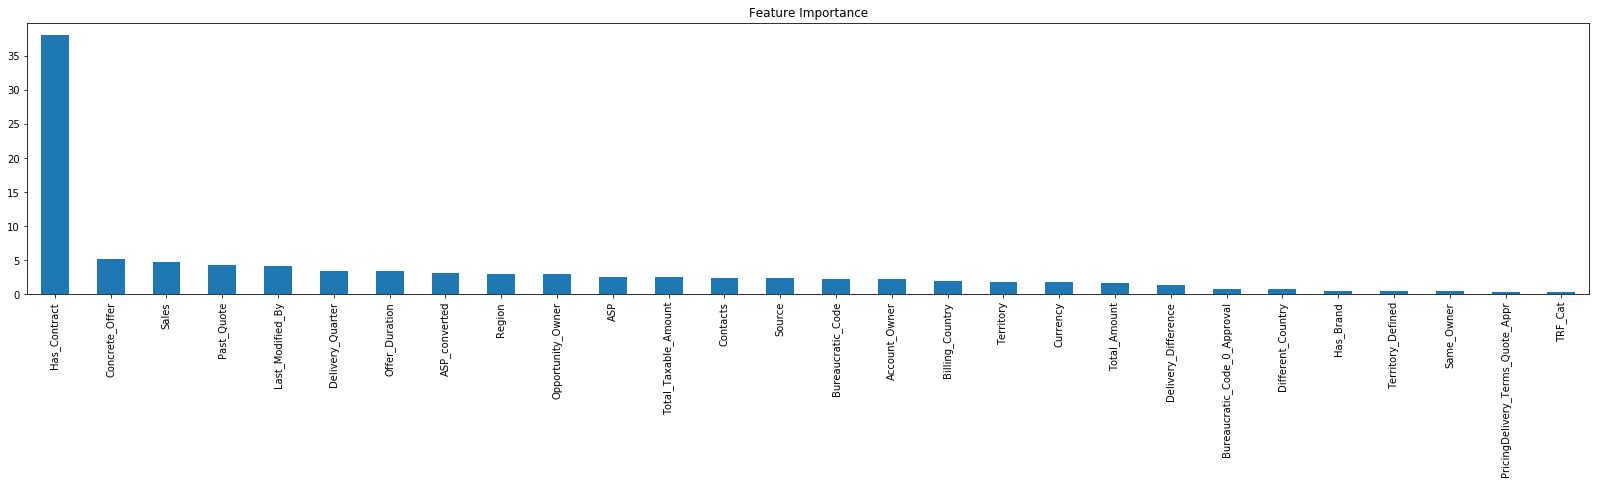

In [29]:
predictors = [x for x in x_train.drop(target, axis = 1).columns]
feat_imp = pd.Series(model.feature_importances_, predictors).sort_values(ascending = False)
feat_imp = feat_imp[0:28]
plt.rcParams['figure.figsize'] = 28, 5
feat_imp.plot(kind = 'bar', title = 'Feature Importance')

In [31]:
print feat_imp

Has_Contract                        37.953640
Concrete_Offer                       5.210771
Sales                                4.763363
Past_Quote                           4.322503
Last_Modified_By                     4.207443
Delivery_Quarter                     3.484346
Offer_Duration                       3.453409
ASP_converted                        3.138373
Region                               3.036068
Opportunity_Owner                    3.029542
ASP                                  2.576806
Total_Taxable_Amount                 2.569290
Contacts                             2.462126
Source                               2.353637
Bureaucratic_Code                    2.281066
Account_Owner                        2.193977
Billing_Country                      1.998147
Territory                            1.860005
Currency                             1.800263
Total_Amount                         1.687755
Delivery_Difference                  1.406141
Bureaucratic_Code_0_Approval      

In [32]:
bad = x_test_pred[(x_test_pred.Prediction > 0.5) & (x_test_pred.Stage == 0) | (x_test_pred.Prediction < 0.5) & (x_test_pred.Stage == 1)]

In [33]:
bad

,Region,Territory,PricingDelivery_Terms_Quote_Appr,PricingDelivery_Terms_Approved,Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Bureaucratic_Code,Source,Billing_Country,Opportunity_ID,Sales_Contract_No,Account_Owner,Opportunity_Owner,Currency,Last_Modified_By,ASP,ASP_converted,Delivery_Quarter,Total_Amount,Total_Taxable_Amount,Stage,Contacts,Delivery_Difference,Same_Owner,Has_Brand,Has_Contract,Different_Country,TRF_Cat,Sales,Concrete_Offer,Offer_Duration,Territory_Defined,Past_Quote,Prediction
16116,Americas,NW America,1,0,0,0,Bureaucratic_Code_5,Source_7,United States,12378,None,Person_Name_64,Person_Name_8,None,Person_Name_8,0.6600,0.66000,Q1,1536796.80,1536796.80,1,1,16.0,False,False,False,True,1.0,91,597.0,414.0,True,114.0,0.436950
7462,APAC,Indonesia,1,0,1,0,Bureaucratic_Code_5,Source_9,Indonesia,4589,3306,Person_Name_63,Person_Name_11,None,Person_Name_63,0.3900,0.39000,Q3,184080.00,184080.00,0,1,15.0,False,False,True,False,0.0,26,357.0,145.0,True,189.0,0.884627
374,EMEA,Germany,1,1,0,0,Bureaucratic_Code_4,Source_9,Germany,154,30,Person_Name_4,Person_Name_4,None,Person_Name_47,0.5200,0.58817,Q2,4375800.00,4375800.00,0,1,73.0,False,False,True,False,2.0,28,175.0,67.0,True,265.0,0.959015
6527,APAC,India,1,1,1,1,Bureaucratic_Code_4,None,India,4041,2500,Person_Name_60,Person_Name_60,None,Person_Name_47,0.2900,0.29000,Q3,116928.00,116928.00,0,1,61.0,False,False,True,False,0.0,10,138.0,NaN,True,NaN,0.881453
11550,Americas,NE America,0,0,0,0,Bureaucratic_Code_4,None,United States,7079,4446,Person_Name_38,Person_Name_3,None,Person_Name_3,NaN,NaN,Q3,2300.00,82320.00,0,2,0.0,False,False,True,True,0.0,5,181.0,101.0,True,95.0,0.939891
11648,APAC,Australia,1,1,1,1,Bureaucratic_Code_4,None,Australia,7119,4075,Person_Name_43,Person_Name_43,None,Person_Name_43,0.3800,0.38000,Q2,73150.00,365750.00,0,5,28.0,True,False,True,False,0.0,231,98.0,NaN,True,NaN,0.517132
13630,Americas,NW America,1,1,1,1,Bureaucratic_Code_4,None,United States,8295,None,Person_Name_8,Person_Name_8,None,Person_Name_8,NaN,NaN,Q2,2947.00,118307.00,1,2,4.0,True,False,False,True,0.0,52,7.0,NaN,True,NaN,0.123870
10105,Japan,None,1,1,0,0,Bureaucratic_Code_4,None,Japan,6357,3307,Person_Name_50,Person_Name_50,None,Person_Name_47,NaN,NaN,Q4,1200000.00,4348535.00,0,5,0.0,False,False,True,False,0.0,2124,26.0,0.0,False,111.0,0.923443
6739,EMEA,Poland,1,1,0,0,Bureaucratic_Code_4,None,Poland,4166,2110,Person_Name_4,Person_Name_4,None,Person_Name_47,0.4200,0.47506,Q2,42630.00,89891.25,0,3,3.0,False,False,True,False,0.0,20,31.0,15.0,True,275.0,0.958759
7464,APAC,Indonesia,0,0,0,0,Bureaucratic_Code_4,None,Indonesia,4591,3981,Person_Name_63,Person_Name_63,None,Person_Name_63,0.3900,0.39000,Q2,196560.00,196560.00,0,1,7.0,True,False,True,False,1.0,2,259.0,238.0,True,-4.0,0.935591


In [34]:
bad.Stage.value_counts()

0    85
1    19
Name: Stage, dtype: int64

In [35]:
validation_file = "Validacion_ECI_2020.csv"
vali = pd.read_csv(validation_file)
validation = preprocess(vali)
leak = ["Opportunity_ID", "Sales_Contract_No"]
pred = model.predict_proba(validation.drop(leak, axis = 1))[:,1]

# agrupo por Opportunity_ID para dar una sola prediccion por solicitud

pred = pd.DataFrame(pred, index = validation.index, columns = ["Prediction"])
validation = validation.join(pred)

answer = pd.DataFrame(validation.groupby("Opportunity_ID", as_index = False)["Prediction"].mean())

In [36]:
prev = pd.read_csv("acceptable/submission_23.csv", names=["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.9983615312482262

In [38]:
prev = pd.read_csv("acceptable/submission_11.csv", names = ["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.9922212567986579

In [41]:
prev = pd.read_csv("best/modelcat_pred.csv", names = ["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.9968206417559818

In [42]:
answer.to_csv("acceptable/submission_33.csv", header = False, index = False)

In [34]:
#p = prev.merge(answer, on = "Opportunity_ID")

In [35]:
#p["New_Prediction"] = (p.Prediction_x + p.Prediction_y) / 2.0

In [36]:
#pp = p[["Opportunity_ID", "New_Prediction"]]
#pp.to_csv("submission_24.csv", header = False, index = False)